In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from explorer_helper import *

# We expect long tables...
pd.options.display.max_rows = 999

# Server Executation

Example of server execution (disabled since HPC connection is not setup):

```python
settings.MODE = settings.MODES.SERVER
settings.SAVE = True

SGPR = {
    'name': 'SGPR',
    'kwargs': {
        'learning_rate': 0.1,
        'n_iter': 500,
        'nn_kwargs': {'layers': None},
        'gp_kwargs': {'inducing_points': 100},
        'use_double_precision': True,
    },
}

DKLSGPR = {
    'name': 'SGPR',
    'kwargs': {
        'do_pretrain': True,
        'pretrain_n_iter': 500,
        'learning_rate': 0.01,
        'n_iter': 300,
        'nn_kwargs': {'layers': [1]},
        'gp_kwargs': {'inducing_points': 100},
        'use_double_precision': True,
    },
}

transformer = {
    'name': 'ActiveSubspace',
    'kwargs': {
        'output_dim': 1
    }
}

models = [
    DKLSGPR,
    {
        'name': 'TransformerModel',
        'kwargs': {
            'transformer': transformer,
            'prob_model': SGPR,
        },
    },
]

functions = [
    {'name': 'ActiveSubspaceArbitrary1D', 'kwargs': {'D': 100}},
    {'name': 'ActiveSubspaceArbitrary1D', 'kwargs': {'D': 1000}},
 ]

for func in functions:
    for model in models:
        # Helper function to wraps all model in a NormalizerModel
        config = normalize_config({
            'tag': 'demo',
            'obj_func': func,
            'model': model,
            'gp_use_derivatives': model.get('name') == 'TransformerModel',
            'gp_samples': 20 * func.get('kwargs').get('D'),
        })
        run = execute(config_updates=config)
```

# Local Execution

WARNING - lions - No observers have been added to this run
INFO - lions - Running command 'main'
INFO - lions - Started
INFO - main - Model0: NormalizerModel training on 100 of dim 1
INFO - main - Iter 1/40 - Loss: 1.372
INFO - main - Iter 11/40 - Loss: 0.726


training on 100 data points of dim 1
Loss 1.372212525699909 with hyperparameters: {'outputscale': array(0.69314718), 'lengthscale': array([[0.69314718]]), 'noise': 0.6932471805574191}


INFO - main - Iter 21/40 - Loss: 0.355
INFO - main - Iter 31/40 - Loss: -0.048
INFO - main - Model0: NormalizerModel predicting on 2500 of dim 1
INFO - main - Model0: NormalizerModel has {'mae': 0.014046977426395256, 'max_err': 0.08131422491953247, 'rmse': 0.02551718957733664, 'mnlp': -0.9189493617662348, 'nmse': 0.00930558008030661}
INFO - main - Model0 has parameters: {'outputscale': array(1.97050551), 'lengthscale': array([[0.28888507]]), 'noise': 0.02125844645920203}


Loss -0.04779402993582451 with hyperparameters: {'outputscale': array(1.88789369), 'lengthscale': array([[0.27389121]]), 'noise': 0.05832855958256781}
Using parameters with loss: -0.32508047985859434
predicting 2500 points using 100 training points
predicting 100 points using 100 training points


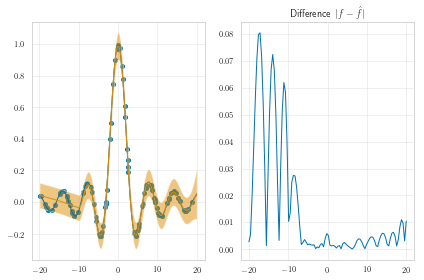

predicting 100 points using 100 training points


<Figure size 432x288 with 0 Axes>

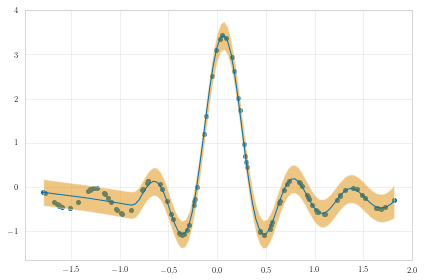

predicting 1000 points using 100 training points
predicting 1000 points using 100 training points


<Figure size 432x288 with 0 Axes>

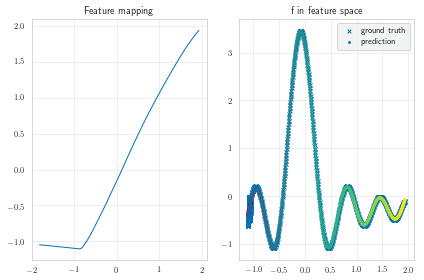

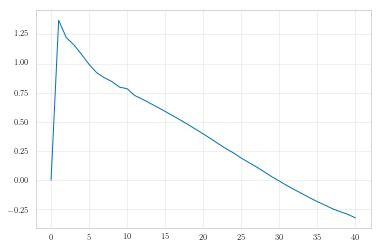

INFO - lions - Result: {'mae': 0.014046977426395256, 'max_err': 0.08131422491953247, 'rmse': 0.02551718957733664, 'mnlp': -0.9189493617662348, 'nmse': 0.00930558008030661, 'time:training': 3.566716999999983, 'time:pred': 0.3088650000000257, 'hyperparameters': {'outputscale': array(1.97050551), 'lengthscale': array([[0.28888507]]), 'noise': 0.02125844645920203}}
INFO - lions - Completed after 0:00:02


In [39]:
# Go into local mode.
settings.MODE = settings.MODES.LOCAL
settings.SAVE = False

# Specify the a [1000-1] DKL model using SGPR for scalability.
SGPR = {
    'name': 'SGPR',
    'kwargs': {
        'learning_rate': 0.1,
        'n_iter': 40,
        'nn_kwargs': {'layers': [1000,1]},
        'gp_kwargs': {'inducing_points': 100},
        'use_double_precision': True,
    },
}

# We automatically wrap the model in a normalixer model.
config = normalize_config({
    'tag': 'demo',
    'obj_func': {'name': 'Sinc'},
    'model': SGPR,
    'gp_samples': 100,
})
run = execute(config_updates=config)

## Exploration

predicting 1000 points using 100 training points
predicting 1000 points using 100 training points


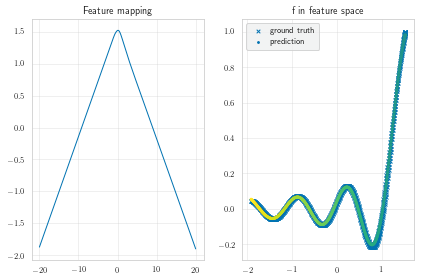

In [37]:
# We can now retrieve the objects for further inspection.
f = run.interactive_stash.obj_func
model = run.interactive_stash.model
run.interactive_stash.model.plot_features(f)
None

# Data exploration

In [9]:
# We can query the mongoDB.
exps_rows_df = get_df(**{'config.tag': "final--embeddings-all"})

# All experiments with the same exp_hash are aggregated.
temp_df = aggregate_results(exps_rows_df)
temp_df = exps_rows_df

# We can then add columns specific for this particular collection of experiments.
def get_model_kwargs(row):
    kwargs = row.config.model.kwargs.model.kwargs.prob_model.get('kwargs', None)
    if kwargs is None:
        kwargs = row.config.model.kwargs.model.kwargs
    return kwargs

def get_lr(row):
    kwargs = get_model_kwargs(row)
    return kwargs.get('learning_rate', None)

def get_n_iter(row):
    kwargs = get_model_kwargs(row)
    return kwargs.get('n_iter', -1)

def get_layers(row):
    kwargs = get_model_kwargs(row)
    return kwargs.nn_kwargs.get('layers', None)

temp_df['f.n']      = temp_df.apply(lambda r: r.config.obj_func.kwargs.get('noise', 0), axis=1)
temp_df['lr_gamma'] = temp_df.apply(lambda r: r.config.model.kwargs.model.kwargs.get('steplr_gamma', 0.1), axis=1)
temp_df['steplr']   = temp_df.apply(lambda r: r.config.model.kwargs.model.kwargs.get('steplr_step_size', 999999), axis=1)
temp_df['wd']       = temp_df.apply(lambda r: r.config.model.kwargs.model.kwargs.get('weight_decay', -1), axis=1)
temp_df['clip']     = temp_df.apply(lambda r: r.config.model.kwargs.model.kwargs.get('grad_clip', -1), axis=1)
temp_df['act']      = temp_df.apply(lambda r: r.config.model.kwargs.model.kwargs.nn_kwargs.get('activation', ''), axis=1)
temp_df['f.D']      = temp_df.apply(lambda r: r.config.obj_func.kwargs.D, axis=1)
temp_df['n_iter']   = temp_df.apply(get_n_iter, axis=1)
temp_df['lr']       = temp_df.apply(get_lr, axis=1)
temp_df['pretrain'] = temp_df.apply(lambda r: r.config.model.kwargs.model.kwargs.get('do_pretrain', False), axis=1)
temp_df['layers']   = temp_df.apply(get_layers, axis=1)
temp_df['layers']   = temp_df.apply(lambda row: tuple(row.layers) if row.layers is not None else (), axis=1)

# We use a helper function to sort based on indexes and 'f'.
view_df(temp_df, 
        indexes=['f.n', 'f.D', 'model', 'layers', 'lr_gamma','steplr', 'lr', 'n_iter',  'wd', 'pretrain', 'act', 'clip', 'N'], 
        cols=['result.rmse', 'result.max_err','result.mae']).sort_index()

result.rmse  \
f.n  f.D  model                         layers             lr_gamma steplr lr   n_iter wd    pretrain act clip N     f                                            
0.00 50   N<DKLGPModel>                 (1,)               0.1      999999 0.01  3000  -1.00 False        -1   1000  ActiveSubspaceArbitrary1D50       0.000654   
                                        (1000, 500, 50, 1) 0.1      1000   0.01  2000   0.01 True          2   1000  ActiveSubspaceArbitrary1D50       0.002048   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.002301   
          N<DNNBLR>                     (1000, 500, 50)    0.1      1000   0.01  2000   0.01 True          2   1000  ActiveSubspaceArbitrary1D50       0.032930   
                                        (1000, 500, 50, 1) 0.1      1000   0.01  2000   0.01 True          2   1000  ActiveSubspaceArbitrary1D50       0.007555   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.004054   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.004154   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.004917   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.005610   
                                        (1000, 500, 50, 5) 0.1      999999 0.01  2000   0.01 True          2   1000  ActiveSubspaceArbitrary1D50       0.010715   
          N<LASSO>                      ()                 0.1      999999 NaN  -1     -1.00 False        -1   1000  ActiveSubspaceArbitrary1D50       0.435326   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.434930   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.434927   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.435049   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.435319   
          N<LinearFromFeatureExtractor> (1000, 500, 50)    0.1      999999 0.01  3000   0.01 False        -1   1000  ActiveSubspaceArbitrary1D50       0.033879   
                                        (1000, 500, 50, 1) 0.1      999999 0.01  5000   0.01 False         2   1000  ActiveSubspaceArbitrary1D50       0.019462   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.075350   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.026696   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.025862   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.022710   
                                        (1000, 500, 50, 5) 0.1      999999 0.01  8000   0.01 False        -1   1000  ActiveSubspaceArbitrary1D50       0.019912   
          N<SGPR>                       (1,)               0.1      999999 0.01  3000  -1.00 True          2   1000  ActiveSubspaceArbitrary1D50       0.000394   
                                                                         

In [ ]:
exp = select_experiment_with_rmse(temp_df, 0.010389)


In [ ]:
def format_layer_list(layers):
    return '[' +  "-".join(map(str,layers)) + ']'

def create_display_df(cols=['RMSE', 'MAX', 'MNLP', 'Time (s)'], noise=False, display_mode=True):
    exps_rows_df2 = exps_rows_df
    exps_rows_df2['has_noise'] = exps_rows_df2.apply(lambda r: bool(r.config.obj_func.kwargs.get('noise', False)),axis=1)
    if noise:
        exps_rows_df2 = exps_rows_df2[exps_rows_df2['has_noise']]
    else:
        exps_rows_df2 = exps_rows_df2[~exps_rows_df2['has_noise']]
    exps_rows_df2 = exps_rows_df2[exps_rows_df2['layers'].isin([(), (1000,500,50,1), (1,)])]
    exps_rows_df2 = exps_rows_df2[~np.isclose(exps_rows_df2['lr_gamma'], 0.5)]
    exps_rows_df2 = exps_rows_df2[exps_rows_df2['steplr'] != 700]

    temp_df = aggregate_result_std(exps_rows_df2, col='result.rmse', format="{:.5f}")
    temp_df['RMSE'] = temp_df['result.rmse.describe']
    temp_df['MAX'] = aggregate_result_std(exps_rows_df2, col='result.max_err', format="{:.6f}")['result.max_err.describe']
    temp_df['MNLP'] = aggregate_result_std(exps_rows_df2, col='result.mnlp', format="{:.3f}")['result.mnlp.describe']
    temp_df['Time (s)'] = aggregate_result_std(exps_rows_df2, col='result.time:training', format="{:.0f}")['result.time:training.describe']

    def get_display_name(r):
        NAMES = {
            'N<T<ActiveSubspace,SGPR>>': 'AS-GP',
            'N<SGPR>': 'DKL',
            'N<LASSO>': 'LASSO',
            'N<DNNBLR>': 'DNNBLR',
            'N<LinearFromFeatureExtractor>': 'DNN',
        }
        name = NAMES[r['model']]
        if name in ['DKL', 'DNNBLR', 'DNN']:
            return name + ' ' + format_layer_list(r['layers'])
        return name

    # Summaries taps    
    temp_df['layers'] = temp_df.apply(get_layers, axis=1)
    temp_df['layers'] = temp_df.apply(lambda row: tuple(row.layers) if row.layers is not None else (), axis=1)

    temp_df['Model'] = temp_df.apply(get_display_name, axis=1)
    temp_df['f'] = temp_df['f.D']

    display_df = view_df(temp_df, indexes=['Model'], cols=cols, ).sort_index()
    display_df = display_df.rename_axis(['Model', 'D'])
    return display_df

display_df = create_display_df(noise=False)
display_df

In [ ]:
save_table(display_df.to_latex(multicolumn=True, multirow=True, escape=False, bold_rows=True, column_format='llccc'), 'demo')

# Local Execution